In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms

from PIL import Image
import os

In [2]:
test_csv = pd.read_csv('test.csv', index_col='image_id')

train_csv = pd.read_csv('train.csv', index_col='image_id')
train_csv

,healthy,multiple_diseases,rust,scab
image_id,,,,
Train_0,0,0,0,1
Train_1,0,1,0,0
Train_2,1,0,0,0
Train_3,0,0,1,0
Train_4,1,0,0,0
...,...,...,...,...
Train_1816,0,0,0,1
Train_1817,1,0,0,0
Train_1818,1,0,0,0


Vamos conta o nome individual de classes para usarmos como peso para entropia cruzada posteriormente.

Estratégias de melhoria de vários pontos que possam ser aplicadas no futuro:
- Data Augmentation: A classe de multiple_diseases, por exemplo, está em uma quantidade bem reduzida. Podemos fazer um augmentation dela.
- Peso na Loss Function: Para as features que aparecem menos podemos associar um peso maior se for importante a acurácia por classe.
- Aumento gradativo do tamanho.

---

As imagens propostas na pasta original estão em uma resolução extremamente elevada. O problema nesse caso é que o treinamento pode demorar muito mais do que o necessário só pela necessidade de se abrir arquivos tão grande. As redes normalmente não consomem imagens maiores que 384x384 pixels. Torna-se mais vantajoso reduzir esse tamanho antes.

### Solução: Carregar tudo em memória (dataset pequeno)
A solução 1 é a mais vantajosa caso tenha a quantidade de RAM necessária parra carregar o dataset inteiro. Como é o meu caso, vamos definir o nosso Dataset personalizado para o caso. Essa classe herda a classe `Dataset` do Pytorch, que basicamente só precisa implementar `__len__()` e `__getitem__()` para seu correto funcionamento.

In [8]:
class ImageFolderToMemory(Dataset):

    def __init__(self, csv_file, root_dir, size, transform=None, save_to_disk=False):
        
        # Load entire dataset from specified location
        self.get_pil = transforms.ToPILImage() # Define uma transformação para obter a imagem em PIL
        self.get_tensor = transforms.ToTensor() # Define uma transformação para obter a imagem em um Tensor
        
        if os.path.exists(f"./tensor_data_{size}px.pt"):
            self.tensor_data = torch.load(f"./tensor_datasets/tensor_data_{size}px.pt")
            self.label_data = torch.load(f"./tensor_datasets/label_data_{size}px.pt")
        else:
            self.train_csv = pd.read_csv(csv_file, index_col='image_id')
            self.root_dir = root_dir
            ext = '.jpg'
            self.tensor_data = torch.Tensor([])
            self.label_data = torch.Tensor([])
            for row, col in self.train_csv.iterrows():
                img = Image.open(root_dir + row + ext).resize(size=(size,size))
                img_tensor = self.get_tensor(img)
                self.tensor_data = torch.cat((self.tensor_data, img_tensor.unsqueeze(0)), dim=0)
                label_tensor = torch.Tensor(list(col)).argmax().float()
                self.label_data = torch.cat((self.label_data, label_tensor.unsqueeze(0)), dim=0)

            if save_to_disk:
                torch.save(self.tensor_data, f"./tensor_datasets/tensor_data_{size}px.pt")
                torch.save(self.tensor_data, f"./tensor_datasets/label_data_{size}px.pt")
                
        self.transform = transform
        
    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.transform:
            sample = (self.apply_tensor_transform(self.tensor_data[idx]), self.label_data[idx])
        else:
            sample = (self.tensor_data[idx], self.label_data[idx])
            
        return sample
    
    def apply_tensor_transform(self, tensor):
        img = self.get_pil(tensor)
        
        return self.transform(img)

In [10]:
class ImageFolderToMemoryTest(Dataset):

    def __init__(self, csv_file, root_dir, size, transform=None, save_to_disk=False):
        
        self.get_pil = transforms.ToPILImage()
        self.get_tensor = transforms.ToTensor()
        
        if os.path.exists(f"./tensor_data_test_{size}px.pt"):
            self.tensor_data = torch.load(f"./tensor_datasets/tensor_data_test_{size}px.pt")
            self.label_data = torch.load(f"./tensor_datasets/label_data_test_{size}px.pt")
        else:
            self.test_csv = pd.read_csv(csv_file, index_col='image_id')
            self.root_dir = root_dir
            ext = '.jpg'
            self.tensor_data = torch.Tensor([])
            for row, col in self.test_csv.iterrows():
                img = Image.open(root_dir + row + ext).resize(size=(size,size))
                img_tensor = self.get_tensor(img)
                self.tensor_data = torch.cat((self.tensor_data, img_tensor.unsqueeze(0)), dim=0)
        
        if save_to_disk:
            torch.save(self.tensor_data, f"./tensor_datasets/tensor_data_test_{size}px.pt")
            torch.save(self.tensor_data, f"./tensor_datasets/label_data_test_{size}px.pt")
        
        self.transform = transform
        
    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        if self.transform:
            return self.transform(self.tensor_data[idx])
        else:
            return self.tensor_data[idx]

Ótimo! Vamos verificar a imagem e corretamente sua label, assim como o tamanho que o tensor principal de imagens está ocupando em memória.

# Create Torch Dataset

Precisamos agora criar nossos datasets e dataloaders para o treino, a validação e o teste utilizados no Pytorch.

### Separação / Treino / Validação

In [11]:
def get_loaders(train_split, batch_size):
    
    for_train = int(train_split*len(plant_dataset))
    train_set, val_set = torch.utils.data.random_split(plant_dataset, lengths=[for_train, len(plant_dataset) - for_train])
    
    # Treinamento
    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, pin_memory=True)

    # Validação
    valid_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    return train_dataloader, valid_dataloader

### Teste

In [12]:
def get_test_loader(test_dataset, batch_size):

    # Treinamento
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    
    return test_dataloader

# Loop de treinamento e checagem

Definimos então os loops de treinamento e checagem.

In [13]:
def get_confusion_matrix(preds, actual, size=8):
    plant_dict = dict(enumerate(train_csv.columns))
    plt.figure(figsize=(size,size))
    a = pd.DataFrame({"Predictions": preds.astype('int'), "Correct": actual.astype('int')}).replace(plant_dict)
    cross_tab = pd.crosstab(a['Predictions'], a['Correct'])
    ax = sns.heatmap(cross_tab, annot=True, fmt='d')
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    plt.xticks(fontsize=14, rotation=0)
    plt.yticks(fontsize=14, rotation=0)
    #b, t = plt.ylim()
    #b += 0.5
    #t -= 0.5
    #plt.ylim(b, t)
    plt.xlabel("Correct Labels", size=20, labelpad=30)
    plt.ylabel("Predictions", size=20, labelpad=30)
    plt.show()
    print('Model Accuracy: {:.3f}%'.format((preds == actual).sum() / len(preds) * 100))

In [14]:
def get_predictions(model, device):
    model = model.to(device)

    predictions = np.array([])
    actual = np.array([])
    with torch.no_grad():
        model.eval()
        for features, labels in valid_dataloader:
            features = features.to(device)
            labels = labels.long().to(device)

            out = model(features)
            predictions = np.concatenate((predictions, out.argmax(dim=1).cpu()), axis=0)
            actual = np.concatenate((actual, labels.cpu()), axis=0)

    return predictions, actual

In [15]:
def check_acuracy(model, device):
    model = model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval()
        for features, labels in valid_dataloader:
            features = features.to(device)
            labels = labels.long().to(device)

            out = model(features)
            truth_tensor = out.argmax(dim=1) == labels
            correct += truth_tensor.sum().item()
            total += len(truth_tensor)

    accuracy = correct / total
    return accuracy, correct, total - correct

In [16]:
def training_loop(n_epochs, model, optimizer, loss_fn, device, lr_scheduler=None, print_every=1, eval_loss_limit_size=-1, verbose=1):
    loss_fn = loss_fn.to(device)
    model = model.to(device)
    
    best_state_dict = model.state_dict()
    best_epoch = 1
    counter = 0
    previous_val_loss = 0
    train_loss_list = []
    val_loss_list = []
    print("Beginning Epoch 1...")
    for epoch in range(1, n_epochs + 1):
        
        model.train()
        train_loss = 0
        for features, labels in train_dataloader:
            features = features.to(device)
            labels = labels.long().to(device)
            
            out = model(features)
            loss = loss_fn(out, labels)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if lr_scheduler:
                lr_scheduler.step()
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for features, labels in valid_dataloader:
                features = features.to(device)
                labels = labels.long().to(device)

                out = model(features)
                val_loss += loss_fn(out, labels).item()
            
            if epoch == 1:
                best_val_loss_ttm = val_loss
            
        if (epoch % print_every == 0 or epoch == 1) and verbose == 1:
            acc, correct, incorrect = check_acuracy(model, 'cuda:0')
            print("Epoch {}/{} : Train Loss {:.5f} | Val Loss {:.5f} | Accuracy: {:.4f}".format(epoch, n_epochs, train_loss, val_loss, acc))
            #if acc > 0.82:
            #    print("DETECTADO SUCESSO APARENTE... FINALIZANDO")
            #    break
        
        if val_loss < best_val_loss_ttm:
            best_val_loss_ttm = val_loss
            best_epoch = epoch
            best_state_dict = model.state_dict()
            counter = 0 
        else:
            counter += 1
            if counter == eval_loss_limit_size and eval_loss_limit_size!=-1:
                print("Loss de validação não caiu por {} épocas consecutivas. Abortando na época {}.".format(eval_loss_limit_size, epoch))
                break
                
        previous_val_loss = val_loss
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
    
    model.load_state_dict(best_state_dict)
    model.cpu()
    loss_fn.cpu()
    print("----- FINALIZADO -----\nMelhor época: {}".format(best_epoch))
    figs, axes = plt.subplots(1, 2, figsize=(19,7))
    sns.lineplot(x=np.arange(1,len(train_loss_list)+1), y=train_loss_list, label='Train', ax=axes[0])
    sns.lineplot(x=np.arange(1,len(val_loss_list)+1), y=val_loss_list, label='Test', color='darkorange', ax=axes[1])
    axes[0].legend(fontsize=15)
    axes[1].legend(fontsize=15)
    plt.show()

# Pesos das classes

In [17]:
def get_weights(pandas_file):
    weights = pandas_file.sum().max() / pandas_file.sum()
    return torch.tensor(weights).clone().detach()

Global manual seed

In [18]:
torch.manual_seed(99)

# Tamanhos 256px e 384px

Vamos pegar 2 dataset: um utilizará imagens de 256px e um idêntico de tamanho 384px.

In [13]:
size = 256
transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Giramos aleatoriamente a imagem na horizontal
                                transforms.RandomVerticalFlip(), # Giramos aleatoriamente a imagem na vertical
                                transforms.RandomPerspective(distortion_scale=0.3), # Mudamos aleatoriamente a perspectiva da imagem
                                transforms.RandomRotation(degrees=10), # Aplicamos uma rotação aleatória de no máximo 10 graus
                                transforms.Resize(size=(size,size)), # Redimensionamos o tamanho da imagem
                                transforms.ToTensor(), # Transformamos em um Tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalizamos nos dados da Image Net
                                                     std=[0.229, 0.224, 0.225])])

plant_dataset = ImageFolderToMemory(csv_file='train.csv', root_dir='./images/', size=size, transform=transform, save_to_disk=True)
print(f"Tamanho do dataset: {len(plant_dataset)} images")
print(f"Size in MB: {plant_dataset.tensor_data.element_size() * plant_dataset.tensor_data.nelement() / 1000000:.0f}")

Tamanho do dataset:  1821
Size in MB: 1432


In [13]:
size = 384
transform = transforms.Compose([transforms.RandomApply([transforms.RandomOrder([transforms.RandomHorizontalFlip(), 
                                                                                transforms.RandomVerticalFlip(), 
                                                                                transforms.RandomPerspective(distortion_scale=0.3),
                                                                                transforms.RandomRotation(degrees=10),
                                                                                transforms.Resize(size=(size,size))])
                                                       ], p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

plant_dataset = ImageFolderToMemory(csv_file='train.csv', root_dir='./images/', size=size, transform=transform, save_to_disk=True)
print("Tamanho do dataset: ", len(plant_dataset))
print("Size in MB: {:.0f}".format(plant_dataset.tensor_data.element_size() * plant_dataset.tensor_data.nelement() / 1000000))

Tamanho do dataset:  1821
Size in MB: 3222


# Treino

Foi escolhido um modelo `ResneSt50` mais utilizado para detecção de objetos do que classificação, mas resolvi utilizá-lo neste caso.

### ResneSt50 - Split 0.7 - Batch Size 16 - 256px

In [13]:
torch.hub.list('zhanghang1989/ResNeSt', force_reload=True)

Using cache found in C:\Users\chris/.cache\torch\hub\zhanghang1989_ResNeSt_master


Beginning Epoch 1...
Epoch 1/30 : Train Loss 105.39076 | Val Loss 40.91933 | Accuracy: 0.5119
Epoch 2/30 : Train Loss 79.25264 | Val Loss 23.01952 | Accuracy: 0.8391
Epoch 3/30 : Train Loss 36.77729 | Val Loss 9.76588 | Accuracy: 0.9068
Epoch 4/30 : Train Loss 18.89023 | Val Loss 6.59742 | Accuracy: 0.9250
Epoch 5/30 : Train Loss 14.76112 | Val Loss 6.55144 | Accuracy: 0.9324
Epoch 6/30 : Train Loss 11.31441 | Val Loss 9.47335 | Accuracy: 0.9013
Epoch 7/30 : Train Loss 11.30360 | Val Loss 9.36112 | Accuracy: 0.9177
Epoch 8/30 : Train Loss 11.17071 | Val Loss 5.91429 | Accuracy: 0.9525
Epoch 9/30 : Train Loss 7.79260 | Val Loss 6.64167 | Accuracy: 0.9397
Epoch 10/30 : Train Loss 6.07491 | Val Loss 7.41115 | Accuracy: 0.9397
Epoch 11/30 : Train Loss 5.32744 | Val Loss 5.82362 | Accuracy: 0.9342
Epoch 12/30 : Train Loss 5.14897 | Val Loss 7.05036 | Accuracy: 0.9305
Epoch 13/30 : Train Loss 3.24332 | Val Loss 11.50423 | Accuracy: 0.9196
Epoch 14/30 : Train Loss 4.13477 | Val Loss 6.92001 |

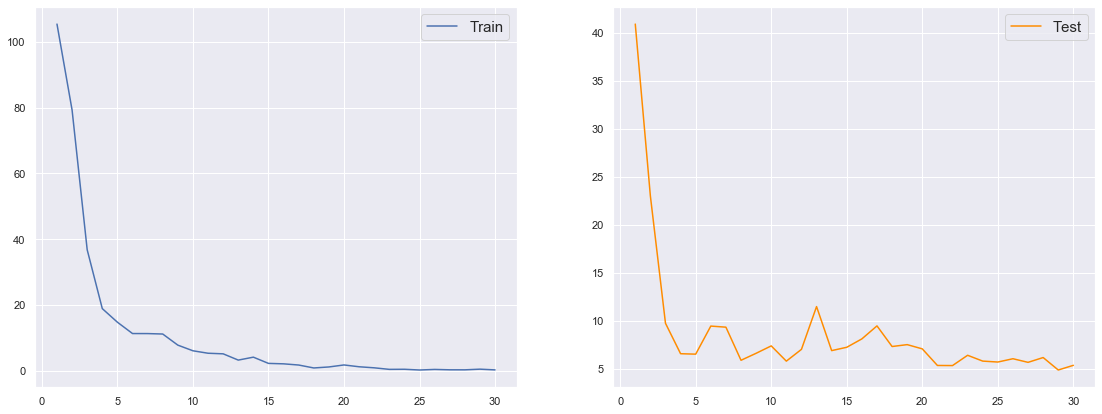

In [16]:
resnest50 = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
in_features = resnest50.fc.in_features
resnest50.fc = nn.Linear(in_features, 4)

# -----------------------------------------------------------
train_dataloader, valid_dataloader = get_loaders(train_split=0.7, batch_size=16)
optimizer = torch.optim.Adam(resnest50.parameters(), lr=0.001)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, # Utilizamos um LR Scheduler com a política de One Cycle
                                                    max_lr=0.0001,
                                                    epochs=30,
                                                    steps_per_epoch=len(train_dataloader),
                                                    pct_start=0.3, 
                                                    anneal_strategy='cos')

weight = torch.tensor([1.3, 1.6, 1.3, 1.8])
loss_fn = nn.CrossEntropyLoss(weight=weight)


training_loop(n_epochs=30, 
              model=resnest50, 
              optimizer=optimizer,
              loss_fn=loss_fn, 
              device='cuda:0', 
              lr_scheduler=lr_scheduler,
              print_every=1,
              eval_loss_limit_size=10, 
              verbose=1)

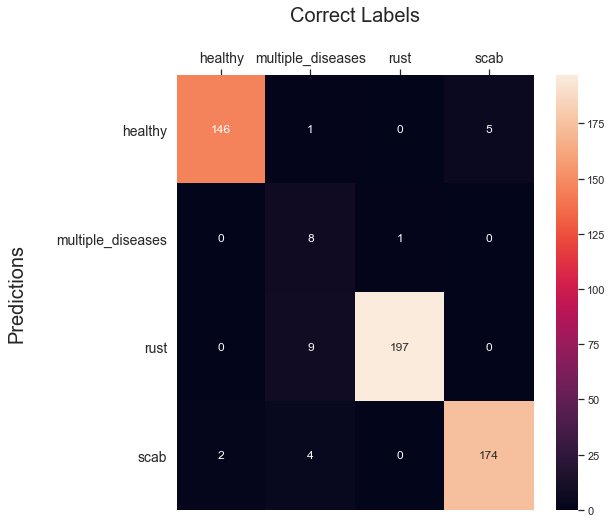

Model Accuracy: 95.978%


In [17]:
preds, actual = get_predictions(resnest50, 'cuda:0')
get_confusion_matrix(preds, actual)

Como pode ser observado, a ausência de exemplos da classe `multiple_diseases` não ajudaram o modelo a identificar os casos corretamente. E, como visto anteriormente na análise exploratória, este realmente era um exemplo difícil de se diferenciar dos outros visualmente.

In [18]:
torch.save(resnest50.state_dict(), './models/resnest50_256px_b16_aug_weighted_lrscheduled_96.pt')

### RETREINO: ResneSt50 - Split 0.7 - Batch Size 16 - 384px

Utilizamos agora a mesma rede e treinamos novamente com imagens um pouco maiores.

Using cache found in C:\Users\chris/.cache\torch\hub\zhanghang1989_ResNeSt_master


Beginning Epoch 1...
Epoch 1/5 : Train Loss 1.56950 | Val Loss 1.14393 | Accuracy: 0.9854
Epoch 2/5 : Train Loss 1.29687 | Val Loss 1.12917 | Accuracy: 0.9890
Epoch 3/5 : Train Loss 1.60441 | Val Loss 0.92707 | Accuracy: 0.9927
Epoch 4/5 : Train Loss 2.10285 | Val Loss 1.23315 | Accuracy: 0.9854
Epoch 5/5 : Train Loss 1.88433 | Val Loss 1.29450 | Accuracy: 0.9890
----- FINALIZADO -----
Melhor época: 3


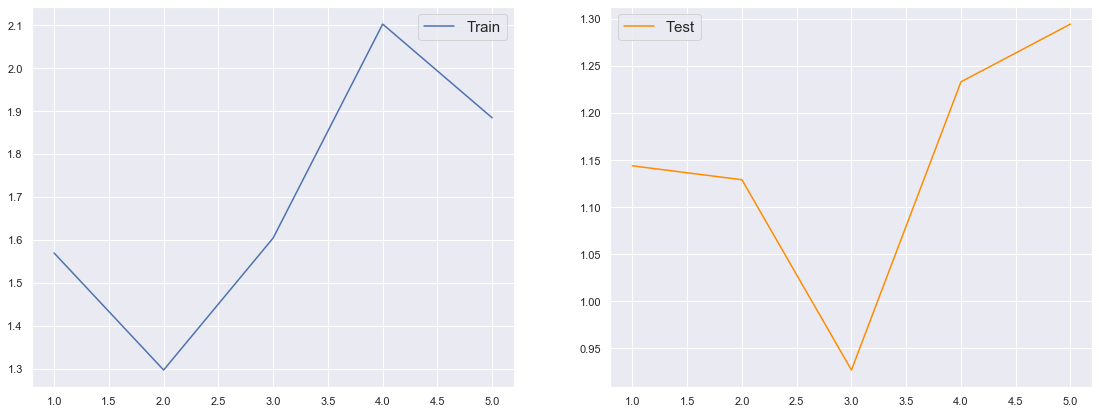

In [14]:
resnest50 = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
in_features = resnest50.fc.in_features
resnest50.fc = nn.Linear(in_features, 4)

resnest50.load_state_dict(torch.load('./models/resnest50RET5_382px_b16_aug_weighted_lrscheduled_99_4.pt'))

# -----------------------------------------------------------
N_EPOCHS = 5
train_dataloader, valid_dataloader = get_loaders(train_split=0.7, batch_size=16)
optimizer = torch.optim.Adam(resnest50.parameters(), lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, 
                                                    max_lr=1e-4,
                                                    epochs=N_EPOCHS,
                                                    steps_per_epoch=len(train_dataloader),
                                                    pct_start=0.3, 
                                                    anneal_strategy='cos')

weight = torch.tensor([1.4, 1.0, 1.4, 1.8])
loss_fn = nn.CrossEntropyLoss(weight=weight)

training_loop(n_epochs=N_EPOCHS,
              model=resnest50, 
              optimizer=optimizer,
              loss_fn=loss_fn, 
              device='cuda:0', 
              lr_scheduler=lr_scheduler,
              print_every=1,
              eval_loss_limit_size=10, 
              verbose=1)

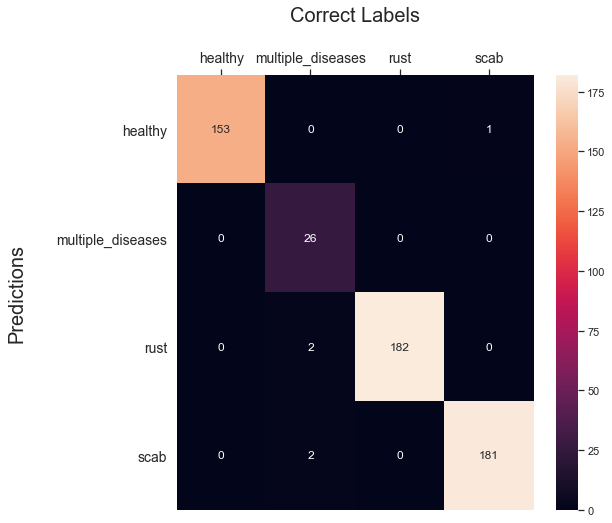

Model Accuracy: 99.086%


In [15]:
preds, actual = get_predictions(resnest50, 'cuda:0')
get_confusion_matrix(preds, actual)

Aumentar o tamanho das imagens impactou em uma qualidade significativamente maior no poder de classificação do modelo. A maioria das folhas pertencente à classe `multiple_diseases` foi corretamente classificada.

In [21]:
torch.save(resnest50.state_dict(), './models/resnest50RET5_384px_b16_aug_weighted_lrscheduled_99_4.pt')

---
---

# Test Dataset

Vamos agora testar nosso modelo e sumeter o resultado para o Kaggle.

In [16]:
size = 384 # Temos de utilizar o mesmo tamanho no qual o modelo foi treinado
test_dataset = ImageFolderToMemoryTest(csv_file='test.csv', root_dir='./images/', size=size, transform=transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                                                                           std=[0.229, 0.224, 0.225]), save_to_disk=True)
test_dataloader = get_test_loader(test_dataset=test_dataset, batch_size=16)

Carregamos então o modelo `ResneSt50` treinado anteriormente.

In [16]:
resnest50 = torch.hub.load('zhanghang1989/ResNeSt', 'resnest50', pretrained=True)
in_features = resnest50.fc.in_features
resnest50.fc = nn.Linear(in_features, 4)

resnest50.load_state_dict(torch.load('./models/resnest50RET5_382px_b16_aug_weighted_lrscheduled_99_4.pt'))

Using cache found in C:\Users\chris/.cache\torch\hub\zhanghang1989_ResNeSt_master


<All keys matched successfully>

In [18]:
def get_predictions_array(model, device, test_dataloader):
    model.to(device)
    predictions_tensor = torch.tensor([]).cuda()
    model.eval()
    with torch.no_grad():
        for features in test_dataloader:
            features = features.to(device)
            out = model(features)
            predictions_tensor = torch.cat((predictions_tensor,out), dim=0)

    return F.softmax(predictions_tensor, dim=1).cpu().detach().numpy()

In [19]:
predictions_array = get_predictions_array(model=resnest50, device='cuda:0', test_dataloader=test_dataloader)
predictions_array

array([[4.7979428e-04, 5.3721652e-03, 9.9405694e-01, 9.1025118e-05],
       [8.4860454e-05, 2.5737972e-03, 9.9721897e-01, 1.2232545e-04],
       [5.4101633e-07, 5.0088856e-06, 1.1635623e-06, 9.9999332e-01],
       ...,
       [1.9107654e-06, 4.3642463e-04, 9.9955970e-01, 1.9430704e-06],
       [9.9996507e-01, 2.0059735e-05, 6.6345269e-06, 8.2346505e-06],
       [1.6483342e-05, 2.6426671e-04, 2.8739152e-05, 9.9969053e-01]],
      dtype=float32)

Esse é o nosso array que representa as probabilidades de cada classe individualmente. Vamos transformá-lo em um `DataFrame` com os nomes corretos para que possamos submeter ao Kaggle.

In [20]:
output_df = pd.DataFrame({'image_id': test_csv.index, 'healthy': predictions_array[:,0], 'multiple_diseases': predictions_array[:,1], 'rust': predictions_array[:,2], 'scab': predictions_array[:,3] })
output_df

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,4.797943e-04,5.372165e-03,0.994057,9.102512e-05
1,Test_1,8.486045e-05,2.573797e-03,0.997219,1.223255e-04
2,Test_2,5.410163e-07,5.008886e-06,0.000001,9.999933e-01
3,Test_3,9.999981e-01,3.953303e-08,0.000002,2.766101e-08
4,Test_4,1.654771e-04,2.886700e-03,0.996685,2.632210e-04
...,...,...,...,...,...
1816,Test_1816,1.111078e-05,7.649749e-04,0.999188,3.635764e-05
1817,Test_1817,9.405266e-05,9.308129e-01,0.001808,6.728540e-02
1818,Test_1818,1.910765e-06,4.364246e-04,0.999560,1.943070e-06
1819,Test_1819,9.999651e-01,2.005974e-05,0.000007,8.234651e-06


Salvamos agora a submissão em um arquivo .csv

In [24]:
output_df.to_csv('./submissions/19_resnest50_384px_b16_aug_weighted_lrscheduled.csv', index=False)

## Concluído

Concluímos então as etapas de treinamento, validação e submissão ao desafio.